In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import cv2
import dlib
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

## install requirements

In [ ]:
# cd "/content/drive/MyDrive/metasoul/MagFace/MagFace/raw"

In [ ]:
# !pip install -r requirements.txt

## Align images to 112x112 pixels with 5 facial landmarks

### facial landmarks 찾기 
https://a292run.tistory.com/entry/Facial-Landmarks-for-Face-Recognition-with-Dlib-1  
- dlib: 얼굴 랜드마크 탐지기  
- 68개의 랜드마크를 찾아줌. -> 우리는 5개의 landmark만 필요로 함.   

In [ ]:
# !wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

# !bunzip2 /content/drive/MyDrive/metasoul/MagFace/shape_predictor_68_face_landmarks.dat.bz2

# datFile =  "/content/drive/MyDrive/metasoul/MagFace/shape_predictor_68_face_landmarks.dat"

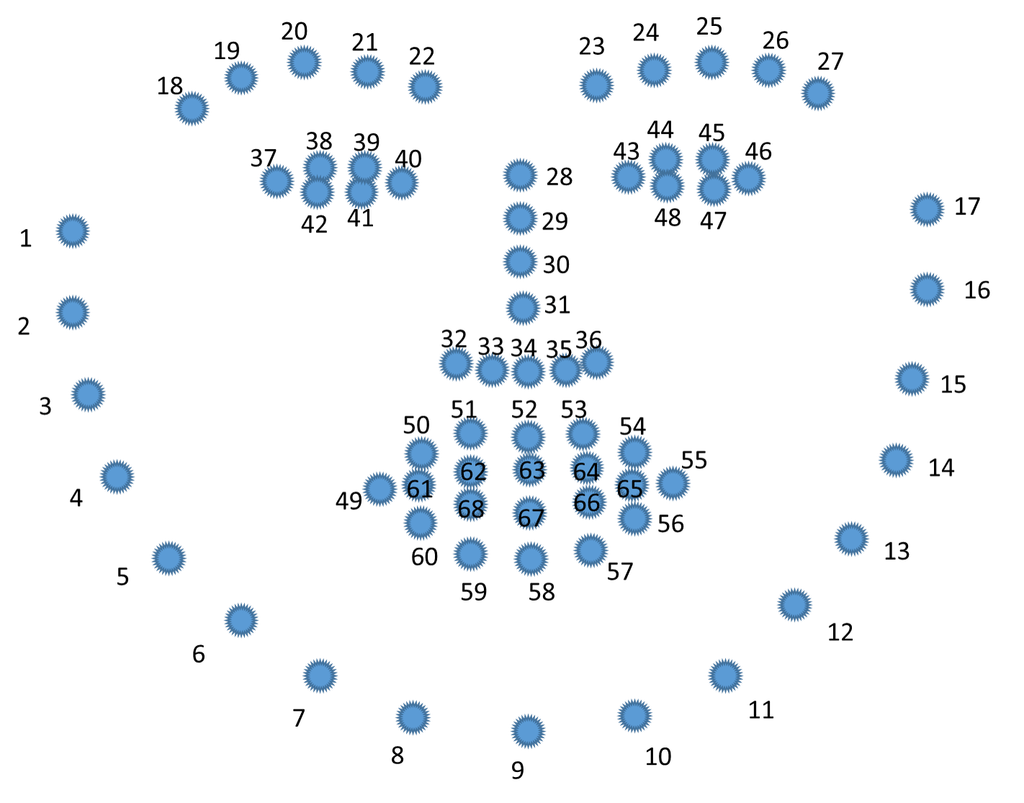

In [ ]:
# 68개의 landmark
from IPython.display import Image
Image('/content/drive/MyDrive/metasoul/MagFace/image/68landmark.png', height = 300, width = 300)

# 직접 해보니까 아래 번호랑 좀 다르게 부여해야 함. -> 숫자가 0부터 시작해야 해서 1씩 빼야 함.

In [ ]:
cd "/content/drive/MyDrive/metasoul/MagFace"

/content/drive/.shortcut-targets-by-id/108INVAjTiyJbjJHlHFU7PqqwjzBGsEk8/metasoul/MagFace


In [ ]:
# 랜드마크 탐지기 load
face_detector = dlib.get_frontal_face_detector() # 정면 사진을 가지고 detection하겠다
landmark_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") # 68개의 점을 가지고 옴.

- 5개의 점만 찾아주는 버전(shape_predictor_68_face_landmarks.dat)으로 구하면 어떻게 돌아가는지 확인하기  
    norm_crop을 적용하면 얼굴의 정면을 찾아주지 못함.

### Reading the image

In [ ]:
def read_img(img_path):
    #read with dlib 
    img = dlib.load_rgb_image(img_path) 
    img_for_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #read with opencv 
    # img = cv2.imread(img_path)[:,:,::-1]

    return img, img_for_show

### face detection & landmark detections

In [ ]:
# 이미지 별로 랜드마크와 route를 찾아줌.
def route_landmark_5_detection(img_path):
    # read_img
    img, img_for_show = read_img(img_path)

    # face_detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray, 1) # upscale: 한 번을 하면 큰 이미지를 인식함.

    # route & landmark detection
    route_list = []
    landmark_list = []
    RIGHT_EYE = list(range(36, 42))
    LEFT_EYE = list(range(42, 48))
    EYES = list(range(36, 48))
    ROUTES = list(range(17, 27)) + [11, 5]

    for k, d in enumerate(faces):  # 얼굴마다
        landmarks = landmark_detector(gray, d) 
        # route detection: 회전시켰을 때 route의 x, y를 결정할 점의 좌표
        for n in ROUTES: 
            x = landmarks.part(n).x 
            y = landmarks.part(n).y 
            route_list.append([x, y]) 

        # landmark detection
        # 오른쪽 눈
        x_right_sum = 0
        y_right_sum = 0
        for n in RIGHT_EYE:
            x_right_sum += landmarks.part(n).x 
            y_right_sum += landmarks.part(n).y 

        x_right = int(x_right_sum / 6)
        y_right = int(y_right_sum / 6)
        right_eye_center = [x_right, y_right]
        landmark_list.append(right_eye_center) 
        # cv2.circle(img_for_show, (x_right, y_right), 2, (255, 255, 0), -1)

        # 왼쪽 눈
        x_left_sum = 0
        y_left_sum = 0
        for n in LEFT_EYE:
            x_left_sum += landmarks.part(n).x 
            y_left_sum += landmarks.part(n).y 

        x_left = int(x_left_sum / 6)
        y_left = int(y_left_sum / 6)
        left_eye_center = [x_left, y_left]
        landmark_list.append(left_eye_center) 
        # cv2.circle(img_for_show, (x_left, y_left), 2, (255, 255, 0), -1)

        # 코: 33, 입, 48, 54
        for n in [33, 48, 54]: 
            x = landmarks.part(n).x 
            y = landmarks.part(n).y 
            landmark_list.append([x, y]) 
            # cv2.circle(img_for_show, (x, y), 2, (255, 255, 0), -1)

    # for i in range(0, len(route_list)-1): 
    #     from_coordinate = tuple(route_list[i])
    #     to_coordinate = tuple(route_list[i+1]) 
    #     img_for_show = cv2.line(img_for_show, from_coordinate, to_coordinate, (255, 255, 0), 1)

    route_array = np.array(route_list)
    landmark_array = np.array(landmark_list)
    return route_array, landmark_array, img_for_show

### Align images to 112x112 pixels
face_align.py  
https://github.com/deepinsight/insightface/blob/cdc3d4ed5de14712378f3d5a14249661e54a03ec/python-package/insightface/utils/face_align.py  

In [ ]:
sys.path.append("/content/drive/MyDrive/metasoul/MagFace")
import face_align_modified

**# 얼굴 외 공간이 너무 많이 포함된 듯함. -> bbox 만들어서 자르기**

In [ ]:
# norm_crop: 얼굴 부분만 자르고, 얼굴 돌림.
def face_alignment(img_path):
    img_route_array, img_landmark_array, img_for_show = route_landmark_5_detection(img_path)
    out = face_align_modified.norm_crop(img_for_show, img_route_array, img_landmark_array)
    return out

In [ ]:
def read_all_file(path): 
    output = os.listdir(path) 
    file_list = [] 
    
    for i in output: 
        if os.path.isdir(path+"/"+i): 
            file_list.extend(read_all_file(path+"/"+i)) 
        elif os.path.isfile(path+"/"+i): 
            file_list.append(path+"/"+i) 
            
    return file_list

In [ ]:
# 오마이걸
omg_list = read_all_file('/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl')
omg_list

['/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin2.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin3.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin5.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin4.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin1.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung1.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung2.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung3.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung5.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung4.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/jiho/jiho1.jpg',
 '/content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/jiho/jiho2.png',
 '/content/drive/MyDri

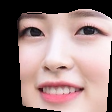

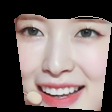

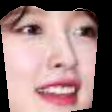

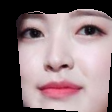

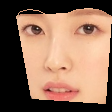

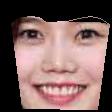

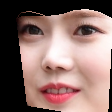

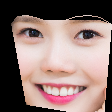

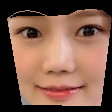

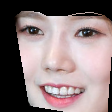

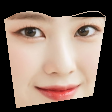

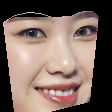

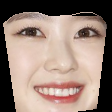

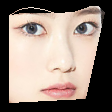

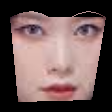

In [ ]:
for i in omg_list:
    aligned_img = face_alignment(i)
    cv2_imshow(aligned_img)

### Prepare a training list with format 'imgname 0 id 0' in each line (id starts from 0)  

In [ ]:
# %cd /content/drive/MyDrive/metasoul/face_data

# !unzip -qq "/content/drive/MyDrive/metasoul/High_Resolution_compressed.zip"

In [ ]:
train_list = []
identity_id = 0 

# 400명, 한 사람 당 300개의 이미지
for i, src_path in enumerate(omg_list):
    if (i != 0) and (i % 5 == 0):
        identity_id += 1
    file = src_path
    train_list.append('imgname {} id {}'.format(file, identity_id))

In [ ]:
train_list

['imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin2.jpg id 0',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin3.jpg id 0',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin5.jpg id 0',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin4.jpg id 0',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/arin/arin1.jpg id 0',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung1.jpg id 1',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung2.jpg id 1',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung3.jpg id 1',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung5.jpg id 1',
 'imgname /content/drive/MyDrive/metasoul/opencv_연습사진/ohmygirl/hyojung/hyojung4.jpg id 1',
 'imgname /content/drive/MyDrive/metasoul/opencv_ᄋ

In [ ]:
len(train_list)

15

In [ ]:
# # train_list를 txt 파일로 저장하기
# with open('/content/drive/MyDrive/metasoul/MagFace/omg.txt','w',encoding='UTF-8') as f:
#     for name in train_list:
#         f.write(name+'\n')

## Modify parameters in run.sh/run_dist.sh/run_dist_cos.sh and run it.

In [ ]:
cd "/content/drive/MyDrive/metasoul/MagFace/MagFace/run"

/content/drive/.shortcut-targets-by-id/108INVAjTiyJbjJHlHFU7PqqwjzBGsEk8/metasoul/MagFace/MagFace/run


In [ ]:
# !chmod +x run.sh

In [ ]:
# %%sh
# /content/drive/MyDrive/metasoul/MagFace/MagFace/run/run.sh
# dist 붙은 거는 GPU 여러 개 필요한 듯 

In [ ]:
!bash /content/drive/MyDrive/metasoul/MagFace/MagFace/run/run.sh

=> parse the args ...
usage: trainer.py [-h] [--arch ARCH] [--train_list TRAIN_LIST] [-j N]
                  [--epochs N] [--start-epoch N] [-b N]
                  [--embedding-size EMBEDDING_SIZE]
                  [--last-fc-size LAST_FC_SIZE] [--lr LR] [--momentum M]
                  [--wd W] [--lr-drop-epoch LR_DROP_EPOCH [LR_DROP_EPOCH ...]]
                  [--lr-drop-ratio LR_DROP_RATIO] [-p N]
                  [--pth-save-fold PTH_SAVE_FOLD]
                  [--pth-save-epoch PTH_SAVE_EPOCH] [--l_a L_A] [--u_a U_A]
                  [--l_margin L_MARGIN] [--u_margin U_MARGIN]
                  [--lambda_g LAMBDA_G] [--arc-scale ARC_SCALE]
                  [--vis_mag VIS_MAG]
trainer.py: error: unrecognized arguments: -- train_list /content/drive/MyDrive/ColabNotebooks/DSL/study_project/metasoul/MagFace/omg.list --workers 8 --epochs 25 --start-epoch 0 --batch-size 512 --embedding-size 512 --last-fc-size 85742 --arc-scale 64 --learning-rate 0.1 --momentum 0.9 --weight-deca